In [1]:
%cd ../open-unmix-pytorch/

/home/olaf/Documents/GitHub/ddspzart/ws_2/open-unmix-pytorch


### Generic Imports

In [68]:
import scipy.signal
from IPython.display import Audio, display
import numpy as np
from tqdm import tnrange, tqdm_notebook
import tqdm
import matplotlib.pyplot as plt
from matplotlib import gridspec
import warnings
import random
import sklearn.preprocessing
import norbert
import musdb
warnings.simplefilter(action='ignore', category=FutureWarning)

### Setup Vocal Separation Scenario

### Load a single track and convert to spectrogram

In [97]:
import torch.utils
import torch
import torch.utils.data

class SimpleMUSDBDataset(torch.utils.data.Dataset):
    def __init__(
        self,
        subset='train',
        split='train',
        target='vocals',
        seq_duration=None,
    ):
        """MUSDB18 Dataset wrapper
        """
        self.seq_duration = seq_duration
        self.target = target
        self.mus = musdb.DB(
            download=True,
            split=split,
            subsets=subset,
        )

    def __getitem__(self, index):
        track = self.mus[index]
        track.chunk_start = random.uniform(0, track.duration - self.seq_duration)
        track.chunk_duration = self.seq_duration
        x = track.audio.T
        y = track.targets[self.target].audio.T
        return torch.tensor(x, dtype=torch.float32), torch.tensor(y, dtype=torch.float32)


    def __len__(self):
        return len(self.mus)

Initialize the dataset

In [98]:
train_dataset = SimpleMUSDBDataset(seq_duration=5.0)
train_sampler = torch.utils.data.DataLoader(train_dataset, batch_size=8, shuffle=True)
print(len(train_dataset))

80


Extract a single example

In [8]:
%pwd

'/home/olaf/Documents/GitHub/ddspzart/ws_2/open-unmix-pytorch'

torch.Size([2, 220500])
torch.Size([1, 1, 2049, 212])


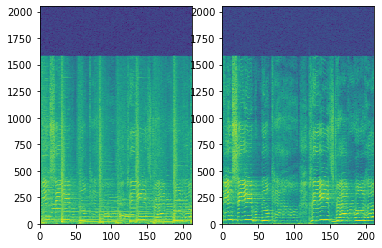

In [157]:
import openunmix

import torch.nn as nn

# create a spectrogram layer
stft = openunmix.transforms.TorchSTFT() # -> shape (nb_samples, nb_channels, nb_bins, nb_frames, complex=2)
spec = openunmix.transforms.ComplexNorm(mono=True) # -> shape (nb_samples, nb_channels(=1 if mono), nb_bins, nb_frames)
transform = nn.Sequential(stft, spec)

x, y = train_dataset[7]
print(x.shape)

# transform the time domain input to spectrograms
X = transform(x[None])
Y = transform(y[None])
print(X.shape)

f, axes = plt.subplots(1, 2)
axes[0].pcolormesh(np.log(X[0, 0, :, :].detach().numpy() ))
axes[1].pcolormesh(np.log(Y[0, 0, :, :].detach().numpy() ))

display(Audio(x, rate=44100))
display(Audio(y, rate=44100))


torch.Size([1, 1, 214, 1025])

## Compute global mean and scale of Dataset

Sample from the dataset and update mean standard deviation using scikit-learn `StandardScaler`.

In [158]:
scaler = sklearn.preprocessing.StandardScaler()

for x, y in tqdm.notebook.tqdm(train_dataset):
    X = transform(x[None]).T
    scaler.partial_fit(X.squeeze().numpy())

# set inital input scaler values
scale = np.maximum(
    scaler.scale_,
    1e-4*np.max(scaler.scale_)
)
mean = scaler.mean_

  0%|          | 0/80 [00:00<?, ?it/s]

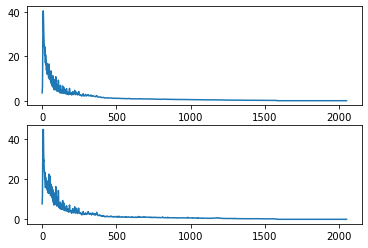

In [159]:
f, axes = plt.subplots(2, 1)
axes[0].plot(mean)
axes[1].plot(scale)


## Set up the model

In [160]:
use_cuda = torch.cuda.is_available()
torch.manual_seed(42)

device = torch.device("cuda" if use_cuda else "cpu")
kwargs = {'num_workers': 1, 'pin_memory': True} if use_cuda else {}

In [226]:
import torch.optim as optim

unmix = openunmix.model.OpenUnmix(
    input_mean=mean,
    input_scale=scale,
    nb_channels=1,
    hidden_size=512,
    max_bin=512,
    nb_bins=2048+1
).to(device)
    
optimizer = optim.RMSprop(unmix.parameters(), lr=0.001)
criterion = torch.nn.MSELoss()

# Train a vocal model 

In [162]:
y.shape

torch.Size([2, 220500])

In [227]:

losses = openunmix.utils.AverageMeter()
unmix.train()

for i in tqdm.notebook.tqdm(range(1)):
    for x, y in tqdm.notebook.tqdm(train_sampler):
        x, y = x.to(device), y.to(device)
        X = transform(x)
        Y = transform(y)
        optimizer.zero_grad()
        Y_hat = unmix(X)
        loss = torch.nn.functional.mse_loss(Y_hat, Y)
        loss.backward()
        optimizer.step()
        losses.update(loss.item(), Y.size(1))
    print(losses.avg)

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

27.15755424499512


## Synthesize



In [143]:
import musdb
mus = musdb.DB(download=True, subsets='test')
track = mus[1]

In [174]:
print(Y.shape)
Y[..., 0].T.shape

torch.Size([8, 1, 2049, 212])


torch.Size([2049, 1, 8])

In [228]:
# Define own separator
target_models = {"vocals": unmix}
own_seperator = openunmix.model.Separator(target_models,nb_channels=1)
audio_torch = torch.tensor(track.audio.T[None, ...]).float().to(device)
print(audio_torch.shape)
own_seperator.forward(audio_torch)

torch.Size([1, 2, 300032])


tensor([[[[ 0.0046, -0.0167,  0.0114,  ..., -0.0771, -0.0804, -0.0834],
          [ 0.1038,  0.1291,  0.1109,  ..., -0.0178, -0.0213, -0.0209]]]],
       grad_fn=<ReshapeAliasBackward0>)

In [ ]:
separator = openunmix.umxl()


In [ ]:
estimates = separator(audio_torch)
estimates.shape

In [ ]:
x = openunmix.predict.separate(audio_torch, rate=44_100 ,separator=own_seperator)